In [123]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import chi2
from matplotlib import pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
def chiSq(modelparam, model, x, y, yerr):
    '''sum up all the square reduced residuals for use in chisquared'''
    return np.sum(((y-model(x, *modelparam))/yerr)**2) 
rhos = [997.38, 1026.6, 1055.8, 1084.7, 1113.0,
        1140.3, 1166.6, 1191.6] # kg/m^3
etas = [0.00093505, 0.0012808, 0.0018249, 0.0027285, 0.0043309,
        0.0074104, 0.013960, 0.029822] # Ns/m^-2
r = 0.007/2 # m

Instead of using a numerical or analytical solution instead fit a simple damped sine curve to the data and then analyse the fitting coefficients

In [124]:
def dampedSine(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.sin(c*x+d) + e

Singular Analysis, treat all the data files as separate and different and plot the values for each of the 3 videos on the same graphs

In [125]:
def analyse(filename, plot=True, prnt=True, ax=None):
    q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
    t = q[0]
    y = q[2]
    # incase we need to skip the first few datapoints
    skip = 0
    y = y[skip:]
    t = t[skip:] - t[skip]
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    ### see comment in multi analyse about errors
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            ax = plt.figure()
        plt.scatter(t, y, label=f"{filename}")
        plt.plot(t, dampedSine(t, *P[0]), color="r", label="Decaying Sine Curve")
        plt.legend()
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

In [126]:
h = 9 # immersion depth of straw, cm
H = 20 # length of straw, cm
g = 9.8 # gravity, ms^-2
D = 0.007 # diameter of straw, m

P_atm = 1030

t_norm = (h*1e-2/g)**-0.5 #normalisation constant, 1e-2 cm to m

# Calculated using "http://www.met.reading.ac.uk/~sws04cdw/viscosity_calc.html"
# 0%, 10%, 20%, ..., 70% by volume
# all values at 23degC
rhos = [997.38, 1026.6, 1055.8, 1084.7, 1113.0,
        1140.3, 1166.6, 1191.6] # kg/m^3
etas = [0.00093505, 0.0012808, 0.0018249, 0.0027285, 0.0043309,
        0.0074104, 0.013960, 0.029822] # Ns/m^-2

def DZ_dt_Lor(Z, t, args):
    Omeg = args[0]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1]]

def LorloadData(filename):
    data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
    time_data = data[:,0]
    z_data = data[:,2]*100 # bc in m

    timeshift = time_data[0] # shifted so that t=0 is the time in video that the cap is released.
    time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
    z_data_clean = z_data[np.isfinite(z_data)]
    z_err = np.full(shape=z_data_clean.shape, fill_value=0.1)
    #z_err = np.sqrt(np.array([0] + [abs(z_data_clean[i] - (z_data_clean[i-1] + z_data_clean[i+1])/2) for i in range(1, len(z_data_clean)-1)] + [0]))+0.01

    #z_0 = 1.954e-2 # height of liquid in straw, cm # calculated as d
    conc = int(filename[0])
    eta = etas[conc] # Ns/m^-2
    rho = rhos[conc] # kg/m^3
    omeg = 16 * eta * (h * 10**-2)**0.5 / (rho * (D/2)**2 * g**0.5)
    d = (1 - P_atm/(rho*(10**-3)*h + P_atm))*H # initial height of liquid in straw
    #d = z_data_clean[0]+h

    def func(t, factor):
        Omeg = omeg*factor
        t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.001)
        Z_soln = sp.integrate.odeint(DZ_dt_Lor, [d, 0.00], t_solnLor, args=((Omeg,),))
        z_soln = Z_soln[:, 0]*h
        t_solnLor /= t_norm # unnormalise to compare to real 
        # find corresponding t values and the z_soln for them
        # searchsorted should be safe as the time data will all be in order
        zout = z_soln[np.searchsorted(t_solnLor, t)-1]
        return zout-h

    return time_data_clean, z_data_clean, z_err, omeg, func

# currently taking the h to be constant at 9cm (which is what we set it as)
# allowing it to vary in the model is interesting but ultimately wrong
def Loranalyse(filename):
    timedata, zdata, zerr, omeg, func = LorloadData(filename)
    P = curve_fit(func, timedata, zdata, p0=(1),  sigma=zerr, absolute_sigma=True)
    vals = P[0]
    err = np.sqrt(np.diag(P[1]))
    h = [9, 0.1]
    factor = [vals[0], err[0]]
    Omeg = [vals[0]*omeg, err[0]*omeg]

    return factor, Omeg, h, func, timedata

def LoranalyseAll(Filenames):
    favg = 0
    tmax = 0
    for file in Filenames:
        try:
            factor, Omeg, h, func, timedata = Loranalyse(file)
            favg += factor[0]
            if max(timedata) > tmax:
                tmax = max(timedata)
        except FileNotFoundError:
            print(f"Datafile {file} not found")
    timedata = np.arange(0, tmax, 0.01)
    plt.plot(timedata[1:], func(timedata[1:], factor[0])+h[0], "y--", label="Lorenceau Model")

In [127]:
vals = []
for perc in range(0, 80, 10):
    v = []
    ax = None #plt.figure()
    for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
        ps = analyse(file, False, False, ax)
        v.append(ps)
    vals.append(v)
vals=np.array(vals)
conc = np.array([[x,x,x] for x in range(0, 80, 10)]).flatten()

# take all data sets, take all 3 videos,
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
SingAs = abs(vals[:, :, 0, 0]).flatten()
SingAerr = vals[:, :, 1, 0].flatten()
SingBs = vals[:, :, 0, 1].flatten()
SingBerr = vals[:, :, 1, 1].flatten()
SingCs = abs(vals[:, :, 0, 2]).flatten()
SingCerr = vals[:, :, 1, 2].flatten()
SingDs = vals[:, :, 0, 3].flatten()
SingDerr = vals[:, :, 1, 3].flatten()
SingEs = vals[:, :, 0, 4].flatten()
SingEerr = vals[:, :, 1, 4].flatten()

def quad(x, a, b, c):
    return a*x**2+b*x+c

def linear(x, a, b):
    return a*x+b

def plotCoeff(x, y, yerr, title_="", ylabel_="", xlabel_="Conc by vol (%)", ax=None, residuals=True, fitter=quad, pguess=(1,1,1)):
    if ax is None:
        fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=pguess, sigma=None, absolute_sigma=True)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, *pfit)
    
    # main data and model plot
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    #ax1.set_title("$A * exp(B*t) * sin(C*t+D) + E$, " + title_)
    ax1.set_xlabel(xlabel_)
    ax1.set_ylabel(ylabel_)

    if residuals:
        #residuals
        xs = x
        yres = y - fitter(xs, *pfit)
        ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
        ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
        ax2.set_xlabel("Conc by vol (%)")
        ax2.set_ylabel("Residuals")

        #histogram
        ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
        ax3.hist(x=yres, bins=8, orientation="horizontal")

        chisqmin = chiSq(pfit, fitter, x, y, yerr)
        DoF = x.size - len((1,1,1))
        redchisqmin = chisqmin / DoF

        p_val = chi2.sf(chisqmin, DoF)

        return pfit, np.sqrt(np.diag(pcov)), redchisqmin, p_val
    else:
        return pfit, np.sqrt(np.diag(pcov))

(array([-9.17381075e-04,  2.48084314e-02,  9.41512880e+00]),
 array([4.45435420e-04, 3.24281883e-02, 4.85912661e-01]))

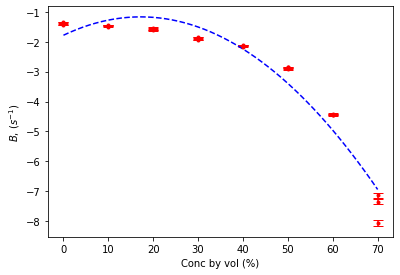

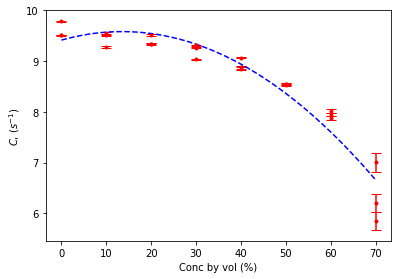

In [128]:
#plot As 
# function of Initial Depth, uninteresting for current experiment
#plotCoeff(conc, SingAs, SingAerr, "Maximum Amplitude $A$", "$A$, ($cm$)")

#plot Bs
# Decay Rate, interesting negative correlation
plotCoeff(conc, SingBs, SingBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False)

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
plotCoeff(conc, SingCs, SingCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False)

#plot Ds
# Phase shift, uninteresting in all.
#plotCoeff(conc, SingDs, SingDerr, "Phase Shift $D$", "$D$, (radians)")

#Plot Es
# A shift of the axes, uninteresting
#plotCoeff(conc, SingEs, SingEerr, "Zero-point Shift $E$", "$E$, ($cm$)")

Multianalysis, combine each of the 3 videos into one data set which is then analysed.

Combine the 3 sets of data for each percentage into one set and analyse. This results in smaller errors and the fitting appears to be better. 70% is still a problem though this is mostly due to it not having an actual frequency as there are very few (if any) oscillations.

In [129]:
def multianalyse(filenames, plot=True, prnt=True, ax=None):
    ts = []
    ys = []
    for filename in filenames:
        q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
        t = q[0]
        y = q[2]
        # incase we need to skip data points,
        # less useful for large datasets 
        # or when using for many different files
        skip = 0
        y = y[skip:]*100 + 9 # m to cm
        t = t[skip:] - t[skip]
        ys.extend(y)
        ts.extend(t)
    y = np.array(ys)
    t = np.array(ts)
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    # sort t, sort y in same way
    way = t.argsort()
    t = t[way]
    y = y[way]
    # errors are currently quite ill defined
    ### could use a damped cosine curve for the error?
    y_err = np.full(shape=y.shape, fill_value=0.001)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            plt.figure()
        plt.scatter(t, y, label=f"{filename[:-2]}")
        plt.plot(t, dampedSine(t, *P[0]), "r--", label="Decaying Sine Curve")
        LoranalyseAll(filenames)
        #plt.xlabel("time (s)")
        #plt.ylabel("Water level above bottom of straw (cm)")
        #plt.xlim(left=-0.1)
        plt.ylim(bottom=-0.5)
        plt.legend(loc="lower right")
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

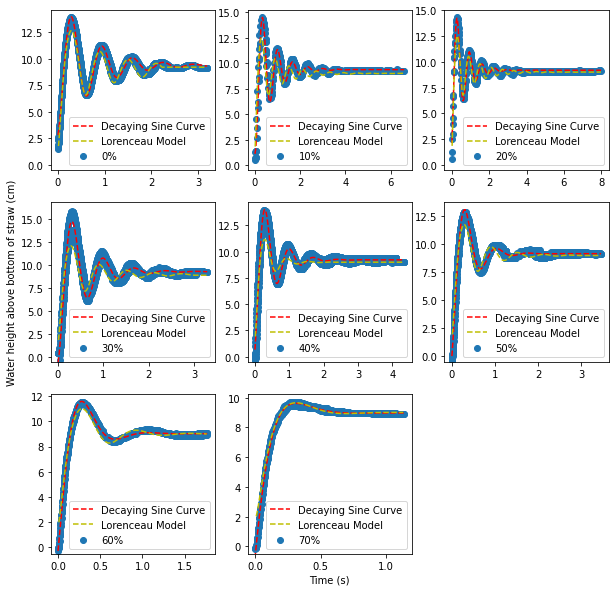

In [130]:
ax = plt.figure(figsize=(10,10))
# 1 2 3
# 4 5 6
# 7 8 9
pt = 1
vals = []
for perc in range(0, 80, 10):
    v = []
    plt.subplot(3,3,pt)
    if pt == 4:
        plt.ylabel("Water height above bottom of straw (cm)")
    if pt == 8:
        plt.xlabel("Time (s)")
    pt += 1
    ps = multianalyse([f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"], True, False, ax=ax)
    v.append(ps)
    vals.append(v)

vals=np.array(vals)
conc = np.array([[x] for x in range(0, 80, 10)]).flatten()

# take all data sets, take the 0th element (3 videos combined into 1),
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
MulAs = abs(vals[:, 0, 0, 0]).flatten()
MulAerr = vals[:, 0, 1, 0].flatten()
MulBs = vals[:, 0, 0, 1].flatten()
MulBerr = vals[:, 0, 1, 1].flatten()
MulCs = abs(vals[:, 0, 0, 2]).flatten()
MulCerr = vals[:, 0, 1, 2].flatten()
MulDs = vals[:, 0, 0, 3].flatten()
MulDerr = vals[:, 0, 1, 3].flatten()
MulEs = vals[:, 0, 0, 4].flatten()
MulEerr = vals[:, 0, 1, 4].flatten()


(array([-0.00203984,  0.06955777, -1.77484044]), array([7.71516760e-04, 5.61672683e-02, 8.41625414e-01]))
(array([-2.54020593e+05, -1.20136254e+00]), array([4.58015227e+04, 4.68952109e-01]))
(array([-9.47069379e-04,  2.64526185e-02,  9.39956019e+00]), array([7.71516707e-04, 5.61672658e-02, 8.41625449e-01]))
(array([-1.33348835e+05,  9.56500308e+00]), array([4.58015239e+04, 4.68952106e-01]))


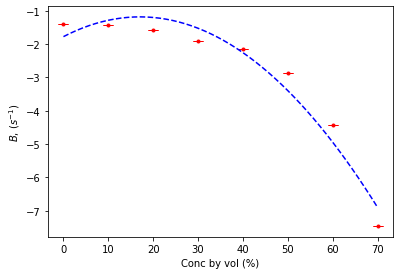

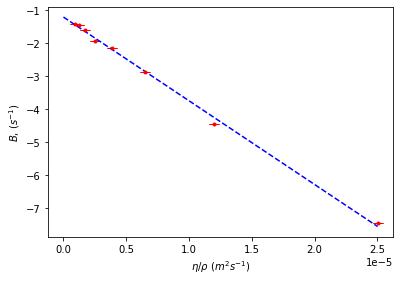

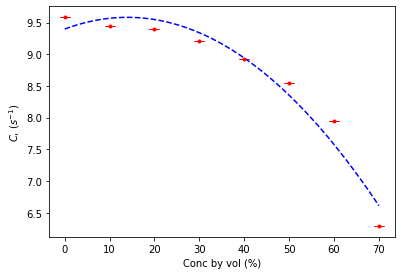

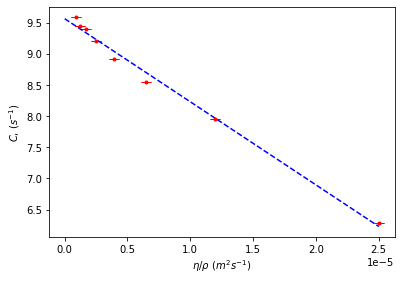

In [133]:
#Only interesting plots are B and C, others are variables to translate the model around to fit as seen in singular analysis
es = np.array(etas)
rs = np.array(rhos)
#plot Bs
# Decay Rate, interesting negative correlation
print(plotCoeff(conc, MulBs, MulBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False))
print(plotCoeff(es/rs, MulBs, MulBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)",\
     xlabel_="$\eta / \\rho$ ($m^2 s^{-1}$)", residuals=False, fitter=linear, pguess=(1,1)))

#print(plotCoeff(conc[:-1], MulBs[:-1], MulBerr[:-1], "Decay Rate $B$, Removed 70%", "$B$, ($s^{-1}$)", residuals=False))

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
print(plotCoeff(conc, MulCs, MulCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False))
print(plotCoeff(es/rs, MulCs, MulCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)",\
     xlabel_="$\eta / \\rho$ ($m^2 s^{-1}$)", residuals=False, fitter=linear, pguess=(1,1)))
#print(plotCoeff(conc[:-1], MulCs[:-1], MulCerr[:-1], "Frequency of Oscillation $C$, Removed 70%", "$C$, ($s^{-1}$)", residuals=False))